313/313 [==============================] - 1s 2ms/step - loss: 0.2077 - accuracy: 0.9350
Epoch 1/10
4/4 [==============================] - 0s 7ms/step - loss: 0.1155 - accuracy: 0.9600
Epoch 2/10
4/4 [==============================] - 0s 7ms/step - loss: 0.0816 - accuracy: 0.9700
Epoch 3/10
4/4 [==============================] - 0s 7ms/step - loss: 0.0338 - accuracy: 1.0000
Epoch 4/10
4/4 [==============================] - 0s 6ms/step - loss: 0.0188 - accuracy: 1.0000
Epoch 5/10
4/4 [==============================] - 0s 6ms/step - loss: 0.0132 - accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 0s 6ms/step - loss: 0.0099 - accuracy: 1.0000
Epoch 7/10
4/4 [==============================] - 0s 7ms/step - loss: 0.0087 - accuracy: 1.0000
Epoch 8/10
4/4 [==============================] - 0s 6ms/step - loss: 0.0072 - accuracy: 1.0000
Epoch 9/10
4/4 [==============================] - 0s 6ms/step - loss: 0.0063 - accuracy: 1.0000
Epoch 10/10
4/4 [==============================

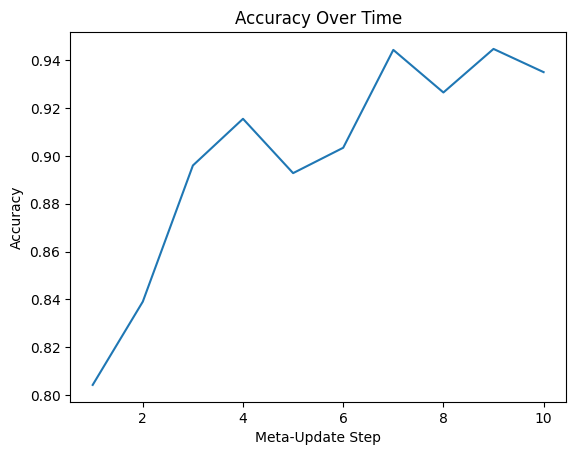

In [7]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))


# Define the model architecture
def create_model():
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Conv2D(
                32, (3, 3), activation="relu", input_shape=(28, 28, 1)
            ),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(10),
        ]
    )
    return model


# Define the MAML model
class MAML(tf.keras.Model):
    def __init__(self, model):
        super(MAML, self).__init__()
        self.model = model

    def train_step(self, data):
        x, y = data
        x = tf.reshape(x, (-1, 28, 28, 1))  # Reshape the input tensor
        y = tf.reshape(y, (-1,))  # Reshape the target labels
        with tf.GradientTape() as tape:
            y_pred = self.model(x)
            loss = self.compiled_loss(y, y_pred)
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x, y = data
        x = tf.reshape(x, (-1, 28, 28, 1))  # Reshape the input tensor
        y = tf.reshape(y, (-1,))  # Reshape the target labels
        y_pred = self.model(x)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}


# Define the meta-learning parameters
num_meta_updates = 10
num_inner_updates = 5
meta_batch_size = 32
inner_batch_size = 10

# Create the MAML model
model = MAML(create_model())
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Initialize variables to store accuracy over time
meta_updates = []
accuracy_over_time = []

# Meta-training loop
for meta_update in range(num_meta_updates):
    # Sample a meta-batch of tasks
    meta_batch = tf.random.shuffle(tf.range(len(x_train)))[:meta_batch_size]

    # Inner loop updates for each task
    for task in meta_batch:
        task_data = (
            x_train[task : task + inner_batch_size],
            y_train[task : task + inner_batch_size],
        )
        for inner_update in range(num_inner_updates):
            model.train_step(task_data)

    # Evaluate on the meta-test set
    _, accuracy = model.evaluate(x_test, y_test)

    # Store the meta-update step and accuracy
    meta_updates.append(meta_update + 1)
    accuracy_over_time.append(accuracy)

# Fine-tuning on a new task
new_task_data = (x_test[:100], y_test[:100])
model.fit(new_task_data[0], new_task_data[1], epochs=10)

# Plot the accuracy over time graph
plt.plot(meta_updates, accuracy_over_time)
plt.xlabel("Meta-Update Step")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Time")
plt.show()